In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import TFTModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

from utils import data_loading as dl

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert datasets to darts TimeSeries

In [18]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS, use_test=False)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY, use_test=False)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS, use_test=False)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE, use_test=False)

electricity.train_df.drop_duplicates(subset="ds", inplace=True)
electricity.val_df.drop_duplicates(subset="ds", inplace=True)


sunspots_series_train = TimeSeries.from_dataframe(sunspots.train_df, "ds", "y")
sunspots_series_val = TimeSeries.from_dataframe(sunspots.val_df, "ds", "y")

electricity_series_train = TimeSeries.from_dataframe(electricity.train_df, "ds", "y", fill_missing_dates=True, freq="H")
electricity_series_val = TimeSeries.from_dataframe(electricity.val_df, "ds", "y", fill_missing_dates=True, freq="H")

mackey_glass_series_train = TimeSeries.from_dataframe(mackey_glass.train_df, "ds", "y")
mackey_glass_series_val = TimeSeries.from_dataframe(mackey_glass.val_df, "ds", "y")

temperature_series_train = TimeSeries.from_dataframe(temperature.train_df, "ds", "y")
temperature_series_val = TimeSeries.from_dataframe(temperature.val_df, "ds", "y")

series = {
    "sunspots": (sunspots_series_train, sunspots_series_val),
    "electricity": (electricity_series_train, electricity_series_val),
    "mackey_glass": (mackey_glass_series_train, mackey_glass_series_val),
    "temperature": (temperature_series_train, temperature_series_val),
}

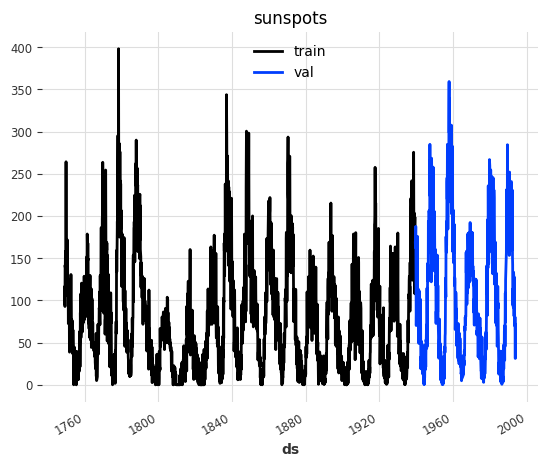

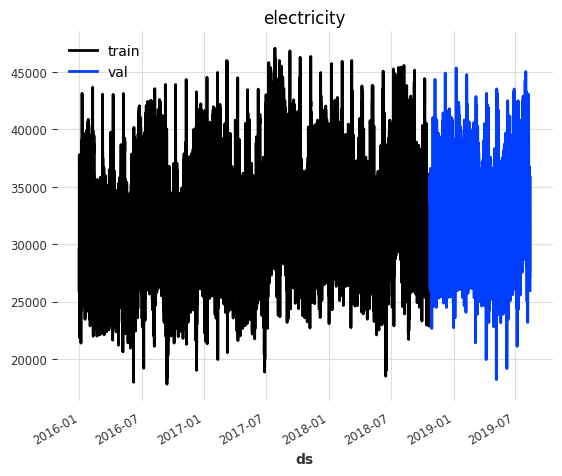

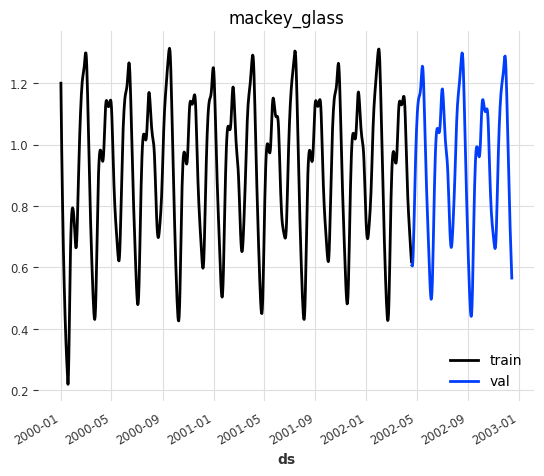

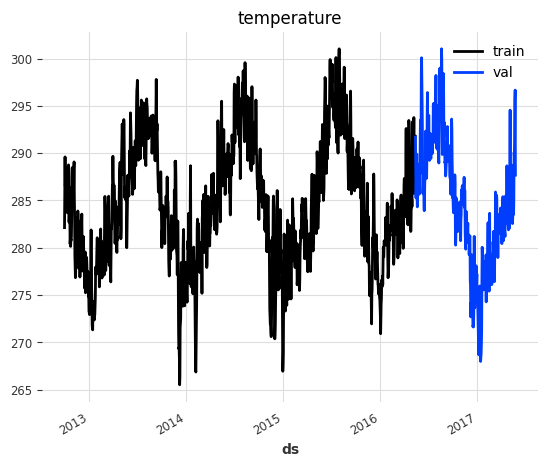

In [19]:
for name, (series_train, series_val) in series.items():
    series_train.plot(label="train")
    series_val.plot(label="val")
    plt.title(name)
    plt.show()

# Preprocessing

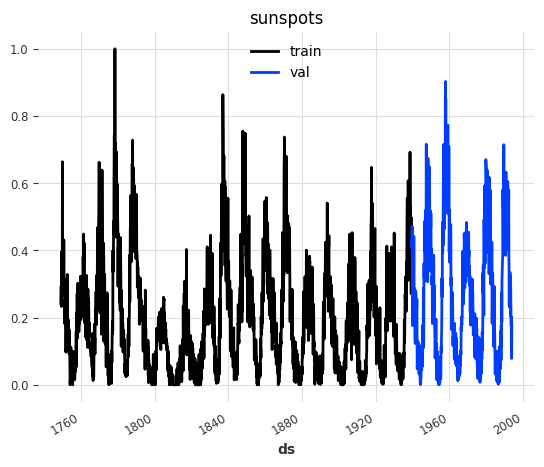

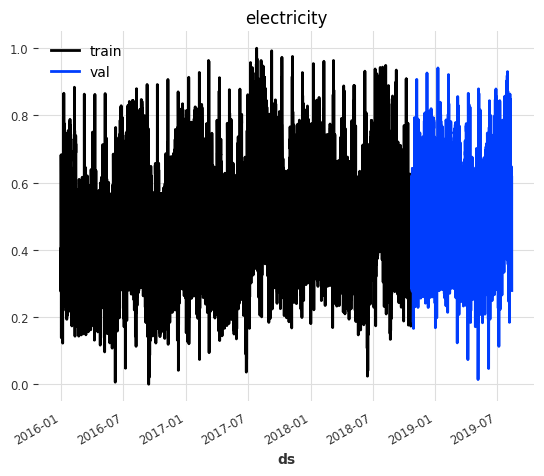

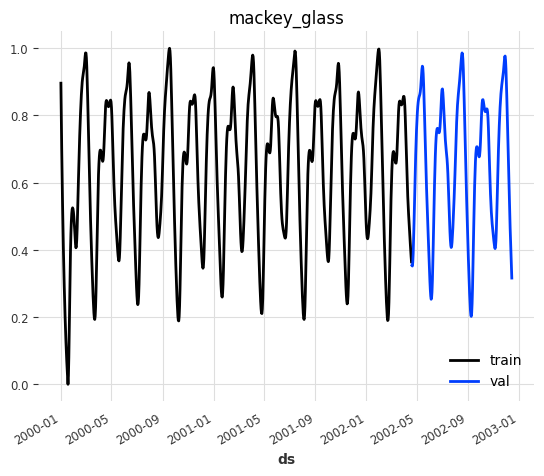

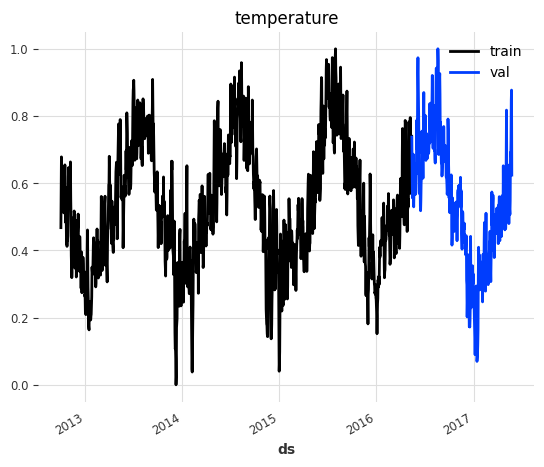

In [20]:
transformer = Scaler()
train_series, val_series = zip(*series.values())
transformer.fit(train_series)

transformed_train_series, transformed_val_series = transformer.transform(train_series), transformer.transform(val_series)
transformed_series = {
    name: (transformed_train_series[i], transformed_val_series[i])
    for i, name in enumerate(series.keys())
}

filler = MissingValuesFiller()
transformed_series = {
    name: (filler.transform(train_series), filler.transform(val_series))
    for name, (train_series, val_series) in transformed_series.items()
}

for name, (series_train, series_val) in transformed_series.items():
    series_train.plot(label="train")
    series_val.plot(label="val")
    plt.title(name)
    plt.show()

# Prepare covariates 


In [21]:
for name, (series_train, series_val) in transformed_series.items():
    print(f"{name}: {series_train.freq}")

sunspots: <MonthEnd>
electricity: <Hour>
mackey_glass: <Day>
temperature: <Day>


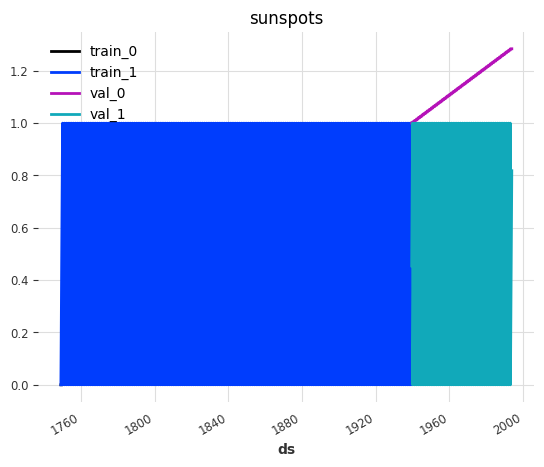

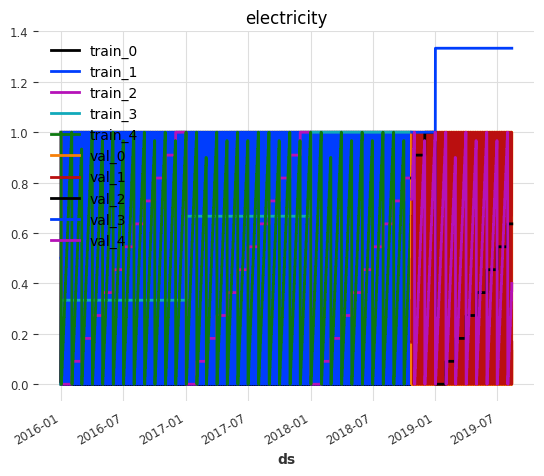

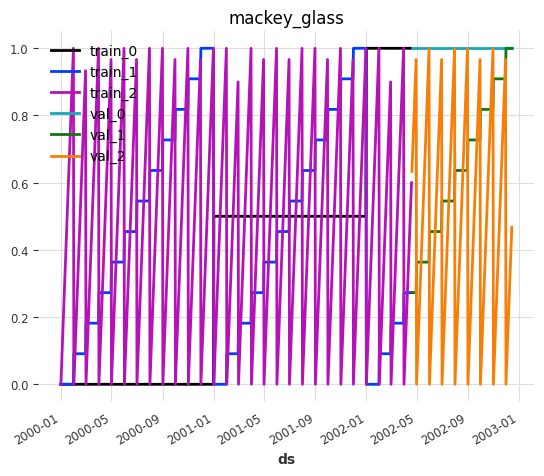

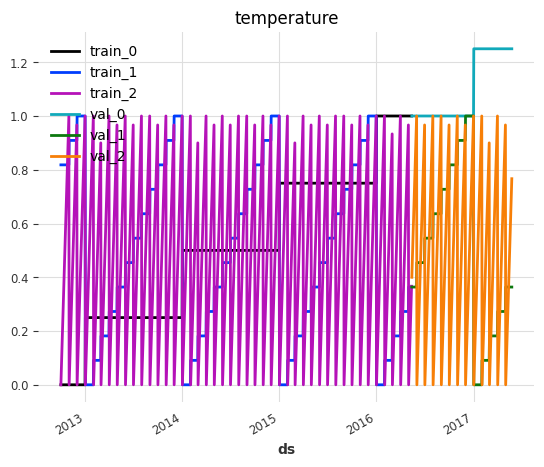

In [22]:
def get_covariates(series: TimeSeries, attributes: list[str]) -> TimeSeries:
    covariates = [datetime_attribute_timeseries(series, attribute=attribute) for attribute in attributes]
    return concatenate(covariates, axis=1)


covariates = {
    "sunspots": (get_covariates(sunspots_series_train, ["year", "month"]), get_covariates(sunspots_series_val, ["year", "month"])),
    "electricity": (get_covariates(electricity_series_train, ["hour", "weekday", "month", "year", "day"]), get_covariates(electricity_series_val, ["hour", "weekday", "month", "year", "day"])),
    "mackey_glass": (get_covariates(mackey_glass_series_train, ["year", "month", "day"]), get_covariates(mackey_glass_series_val, ["year", "month", "day"])),
    "temperature": (get_covariates(temperature_series_train, ["year", "month", "day"]), get_covariates(temperature_series_val, ["year", "month", "day"])),
}

covariates_scalers = {
    name: Scaler() for name in covariates.keys()
}

covariates_scaled = {
    name: (covariates_scalers[name].fit_transform(covariates[name][0]), covariates_scalers[name].transform(covariates[name][1]))
    for name in covariates.keys()
}

for name, (series_train, series_val) in covariates_scaled.items():
    series_train.plot(label="train")
    series_val.plot(label="val")
    plt.title(name)
    plt.show()

# Define model

In [7]:
import torch as th 

quantiles = [
    # 0.01,
    # 0.05,
    0.1,
    # 0.15,
    # 0.2,
    0.25,
    # 0.3,
    # 0.4,
    0.5,
    # 0.6,
    # 0.7,
    0.75,
    # 0.8,
    # 0.85,
    0.9,
    # 0.95,
    # 0.99,
]
input_chunk_length = 100
forecast_horizon = 1

def get_model(input_chunk_length: int=100, output_chunk_length: int=1, stochastic: bool=True, epochs=300):
    likelihood = QuantileRegression(quantiles=quantiles) if stochastic else None
    loss = None if stochastic else th.nn.MSELoss()

    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        batch_size=64,
        n_epochs=epochs,
        add_relative_index=False,
        add_encoders=None,
        likelihood=likelihood,
        loss_fn=loss,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "cpu"},
        optimizer_kwargs={"lr": 0.01},
    )
    return model

# Fit model and save weights

In [13]:
from pathlib import Path
from datetime import datetime
MODEL_DIR = Path().cwd().parent / "models/tft"

In [14]:
def eval_model(model: TFTModel, n, series_val, name, n_samples=10):
    prediction = model.predict(n, num_samples=n_samples)
    prediction.plot(label="prediction")
    series_val[: n].plot(label="actual")
    plt.title(name)
    plt.show()

sunspots
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


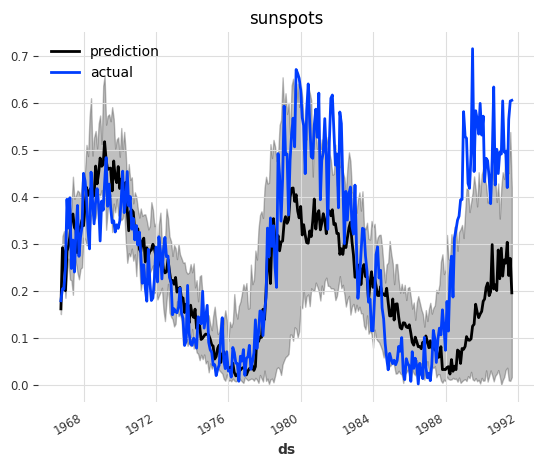

electricity
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


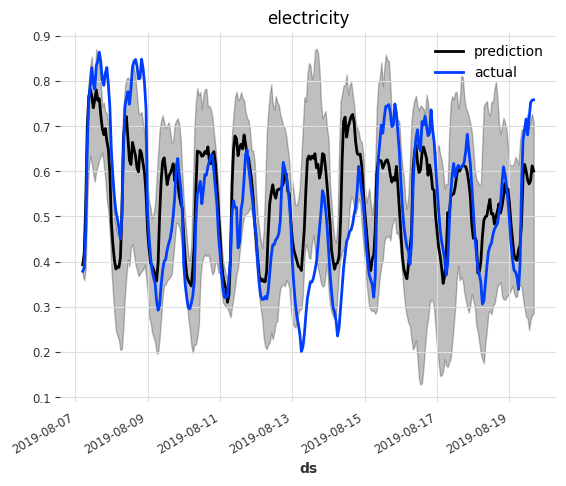

mackey_glass
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


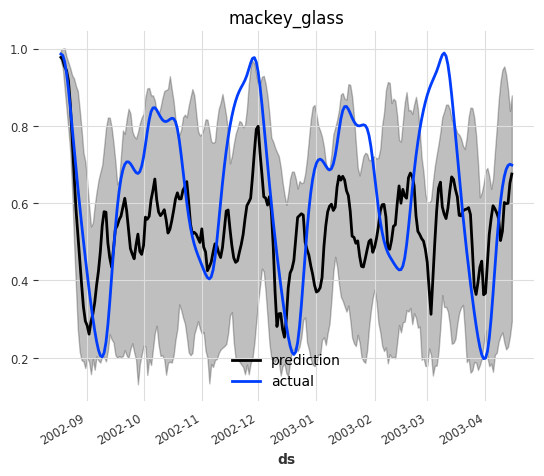

temperature
Predicting DataLoader 0: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


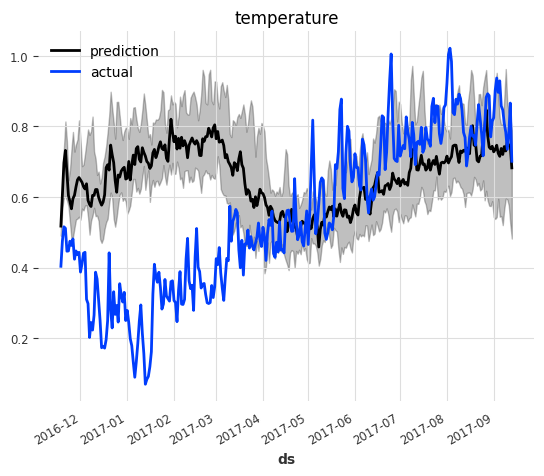

In [8]:
for name, (series_train, series_val) in transformed_series.items():
    print(name)
    model = get_model(input_chunk_length, forecast_horizon)
    model.fit(series_train, verbose=True, num_loader_workers=0)
    model.save(str(MODEL_DIR / (name + f"{datetime.now().strftime('%H:%M:%S')}")))

    horizon = min(3 * input_chunk_length, len(series_val))
    eval_model(model, horizon, series_val, name)


# Evaluate model

In [10]:
model_electricity = get_model().load(str(MODEL_DIR / "electricity08:06:31"))
model_sunspots = get_model().load(str(MODEL_DIR / "sunspots01:52:41"))
model_mackey_glass = get_model().load(str(MODEL_DIR / "mackey_glass08:16:47"))
model_temperature = get_model().load(str(MODEL_DIR / "temperature08:33:50"))

models = {
    "sunspots": model_sunspots,
    "electricity": model_electricity,
    "mackey_glass": model_mackey_glass,
    "temperature": model_temperature,
}

Predicting DataLoader 0: 100%|██████████| 1/1 [00:50<00:00, 50.95s/it]


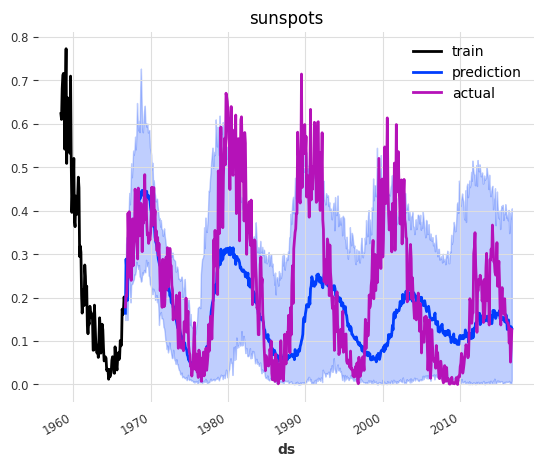

Predicting DataLoader 0: 100%|██████████| 1/1 [00:49<00:00, 49.47s/it]


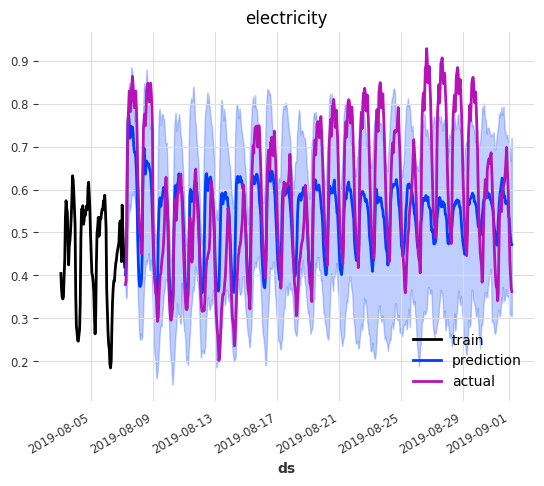

Predicting DataLoader 0: 100%|██████████| 1/1 [00:20<00:00, 20.22s/it]


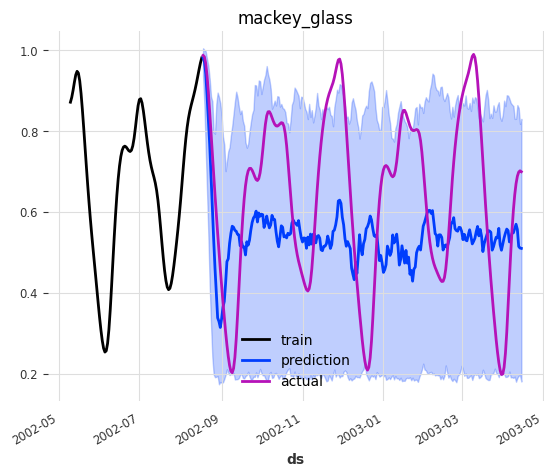

Predicting DataLoader 0: 100%|██████████| 1/1 [00:32<00:00, 32.08s/it]


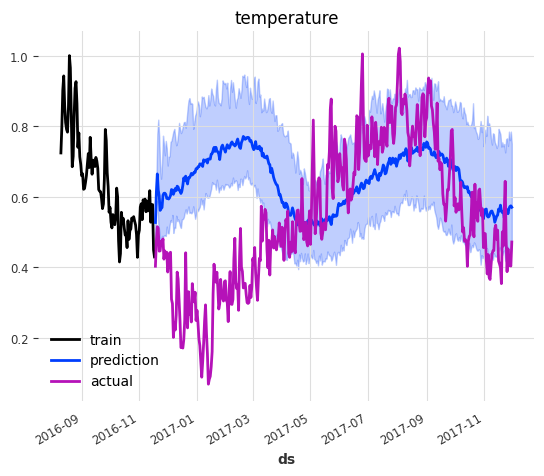

In [15]:
for name, (series_train, series_val) in transformed_series.items():
    horizon = min(6 * input_chunk_length, len(series_val))
    series_train[-input_chunk_length:].plot(label="train")
    eval_model(models[name], horizon, series_val, name, 100)

# multihorizon 

In [23]:
import torch as th 

quantiles = [
    # 0.01,
    # 0.05,
    0.1,
    # 0.15,
    # 0.2,
    0.25,
    # 0.3,
    # 0.4,
    0.5,
    # 0.6,
    # 0.7,
    0.75,
    # 0.8,
    # 0.85,
    0.9,
    # 0.95,
    # 0.99,
]
input_chunk_length = 100
forecast_horizon = 1

def get_model(model_name:str, input_chunk_length: int=100, output_chunk_length: int=1, stochastic: bool=True, epochs=300):
    likelihood = QuantileRegression(quantiles=quantiles) if stochastic else None
    loss = None if stochastic else th.nn.MSELoss()

    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        batch_size=64,
        n_epochs=epochs,
        add_relative_index=True,
        add_encoders=None,
        likelihood=likelihood,
        loss_fn=loss,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "gpu"},
        optimizer_kwargs={"lr": 0.001},
        model_name=model_name,
        save_checkpoints=True,
        work_dir=OUTPUT_DIR
    )
    return model

In [ ]:
for name, (series_train, series_val) in transformed_series.items():
    print(name)
    fut_cov = concatenate(covariates_scaled[name], axis=0).astype(np.float32)
    input_chunk_length = 168
    output_chunk_length = 24

    model = get_model(f"{name}_i{input_chunk_length}_h{output_chunk_length}_{datetime.now().strftime('%H:%M:%S')}",
                      input_chunk_length, output_chunk_length, stochastic=True)
    # model = TFTModel.load("/content/drive/MyDrive/agh/sunspots_h133_20:15:27")
    model.fit(series_train.astype(np.float32), verbose=True, 
              num_loader_workers=2, future_covariates=fut_cov, 
              epochs=60,
              val_future_covariates=fut_cov,
              val_series=series_val.astype(np.float32))
    model.save(
      str(OUTPUT_DIR / f"{name}_i{input_chunk_length}_h{output_chunk_length}_{datetime.now().strftime('%H:%M:%S')}")
    )

    horizon = min(3 * input_chunk_length, len(series_val))
    eval_model(model, horizon, series_val.astype(np.float32), name)

# Load multihorizon models

In [26]:
from utils.predictors import get_tft_weights_covariates

models: dict[dl.DATASET, TFTModel] = {}
for dataset in dl.DATASET:
    path, covariates = get_tft_weights_covariates(dataset, multihorizon=True)
    model = TFTModel.load(str(MODEL_DIR / path), map_location="cpu")
    models[dataset] = model

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


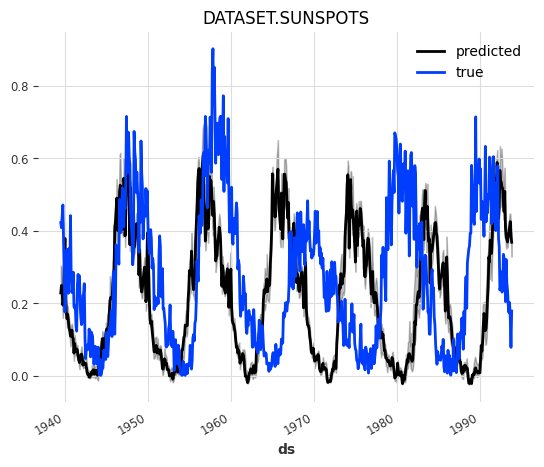

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


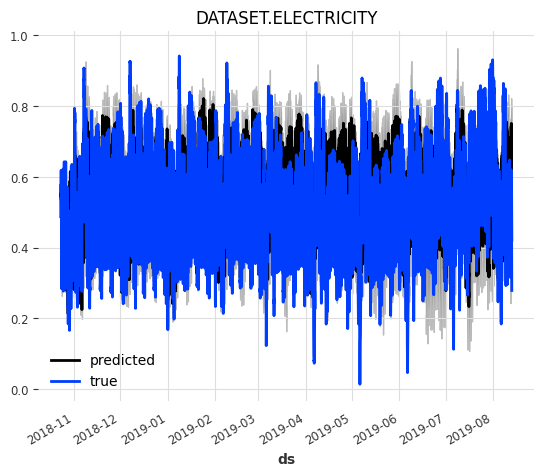

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


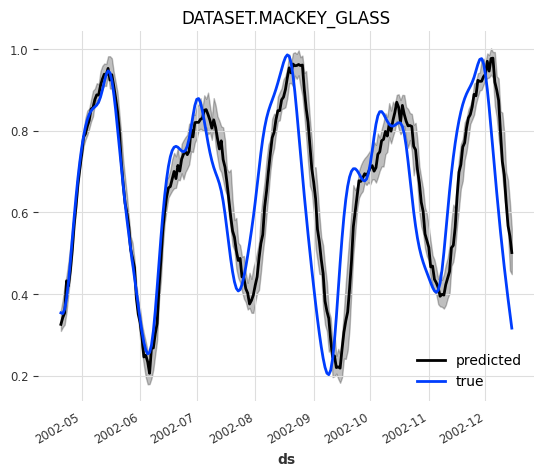

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


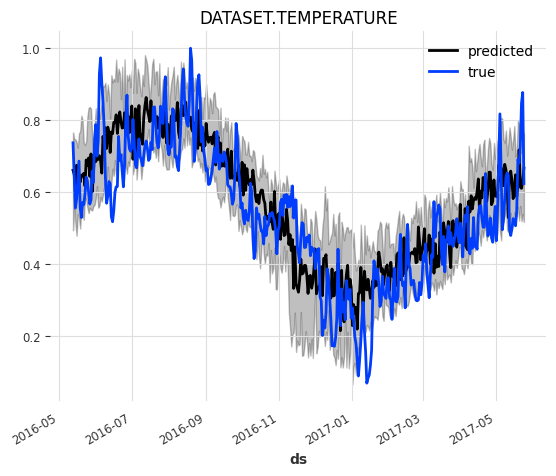

In [30]:
from pytorch_lightning import Trainer

for dataset, model in models.items():
    s_train, s_test = transformed_series[dataset]
    fut_cov = concatenate(covariates_scaled[dataset], axis=0).astype(np.float32)

    s_train = s_train.astype(np.float32)
    s_test = s_test.astype(np.float32)

    model.predict(
        len(s_test),
        series=s_train,
        trainer=Trainer(precision="64", accelerator="cpu"),
        num_samples=10,
        future_covariates=fut_cov,
    ).plot(label="predicted")
    s_test.plot(label="true")
    plt.title(dataset)
    plt.show()
